## Build a Retrieval Augmented Generation (RAG) App: Part 1

In [28]:
import boto3
import faiss
from langchain_aws import ChatBedrockConverse
from langchain_aws import BedrockEmbeddings
from langchain_community.docstore import InMemoryDocstore
from langchain_community.vectorstores import FAISS

In [44]:
bedrock_client = boto3.client("bedrock-runtime", region_name="us-west-1")
model_id = "us.amazon.nova-lite-v1:0"
provider_id = "amazon"
embedding_id = "amazon.titan-embed-text-v2:0"

llm = ChatBedrockConverse(
    model=model_id,
    provider=provider_id,
    temperature=0.5,
    max_tokens=None,
    client=bedrock_client
)

embeddings = BedrockEmbeddings(
    credentials_profile_name="default",  # AWS profile with access
    region_name="us-east-1",
)

In [35]:
embedding_dim = len(embeddings.embed_query("hello world"))
index = faiss.IndexFlatL2(embedding_dim)

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [56]:
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.prompts import ChatPromptTemplate

In [70]:
from langchain_community.document_loaders import S3DirectoryLoader
loader = S3DirectoryLoader("kb-bucket-isaacm")

In [74]:
docs = loader.load()

Cannot set gray non-stroke color because /'P1' is an invalid float value
Cannot set gray non-stroke color because /'P1' is an invalid float value
Cannot set gray non-stroke color because /'P2' is an invalid float value
Cannot set gray non-stroke color because /'P1' is an invalid float value
Cannot set gray non-stroke color because /'P2' is an invalid float value
Cannot set gray non-stroke color because /'P1' is an invalid float value


In [90]:
docs

[Document(metadata={'source': 's3://kb-bucket-isaacm/AI_in_the_Enterprise_lessons_from_7_frontier_companies_1747178371.pdf'}, page_content="AI in the Enterprise\n\nLessons from seven frontier companies\n\nContents\n\nA new way to work\n\nExecutive summary\n\nSeven lessons for enterprise AI adoption\n\nStart with evals Embed AI into your products Start now and invest early Customize and fine-tune your models Get AI in the hands of experts Unblock your developers Set bold automation goals\n\nConclusion\n\nMore resources\n\n2\n\n3 5\n\n6 9 11 13 16 18 21\n\n22\n\n24\n\nAI in the Enterprise\n\nA new way \u2028 to work\n\nAs an AI research and deployment company, OpenAI prioritizes partnering with global companies because our models will increasingly do their best work with sophisticated, complex, interconnected workflows and systems.\n\nWe’re seeing AI deliver significant, measurable improvements on three fronts:\n\n01\n\nWorkforce performance Helping people deliver higher-quality outputs 

In [75]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [76]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

In [77]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise."),
    ("human", "Context: {context}\nQuestion: {question}"),
])

In [78]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    response = llm.invoke(prompt.format_messages(question=state["question"], context=docs_content))
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [82]:
response = graph.invoke({"question": "when should you build an agent?"})
print(response["answer"])

You should build an agent when you need to automate complex workflows independently. Start with a single agent and consider multiple agents for complex logic or when tools become overwhelming.


# Build a Retrieval Augmented Generation (RAG) App: Part 2

In [83]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [84]:
from langchain_core.tools import tool

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [85]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [86]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile(checkpointer=memory)
# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

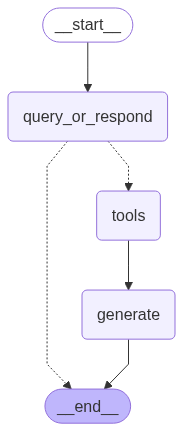

In [87]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [91]:
input_message = "when should you build an agent?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

when should you build an agent?
================================== Ai Message ==================================

<thinking>The question about when to build an agent was already answered in the retrieved information. However, I can provide a more detailed and specific context to enhance understanding. I'll reiterate the key points and emphasize when an agent would be advantageous over other automation methods.</thinking>

You should build an agent when:

- **Complexity in Workflows:** Your workflows are too complex for traditional automation tools. These could include scenarios with a high degree of variability, numerous decision points, or a need for context-aware actions.

- **Adaptability:** You need a system that can adapt to changing situations or user needs without requiring extensive reprogramming.

- **Decision-Making:** The system needs to make decisions based on real-time data and context, rathe

In [69]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================

[{'type': 'text', 'text': "<thinking>The User has asked for more information on the common ways of doing Task Decomposition. The 'retrieve' tool can be used to fetch this information. So, I will use the 'retrieve' tool again with a modified query to specifically ask for common ways of doing Task Decomposition.</thinking> "}, {'type': 'tool_use', 'name': 'retrieve', 'input': {'query': 'common ways of doing Task Decomposition'}, 'id': 'tooluse_Z9zBEXGoRKqTizJfas8rIg'}]
Tool Calls:
  retrieve (tooluse_Z9zBEXGoRKqTizJfas8rIg)
 Call ID: tooluse_Z9zBEXGoRKqTizJfas8rIg
  Args:
    query: common ways of doing Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23